In [1]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# load the dataset
emotions = pd.read_csv("./data/emotion.csv")

In [3]:
# check if there is any null value in the dataset
emotions.head()

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


In [4]:
len(emotions)

1455563

In [5]:
idf = pd.read_csv('./data/data_identification.csv')

In [6]:
len(idf)

1867535

In [7]:
tweets = pd.read_json("./data/tweets_DM.json", lines=True)

In [8]:
print(f'# of records in tweets_DM: {len(tweets)}')
display(tweets.head())

# of records in tweets_DM: 1867535


,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [9]:
# process columns from _source
tweets['hashtags'] = tweets['_source'].apply(lambda x: x['tweet']['hashtags'])
tweets['tweet_id'] = tweets['_source'].apply(lambda x: x['tweet']['tweet_id'])
tweets['text'] = tweets['_source'].apply(lambda x: x['tweet']['text'])

In [10]:
tweets = tweets.merge(idf, on='tweet_id')

In [11]:
# split dataset using identification
tweets_train = tweets[tweets['identification'] == 'train']
tweets_test = tweets[tweets['identification'] == 'test']

In [12]:
# checking for dataset length
len(tweets) == len(tweets_train) + len(tweets_test)

True

In [13]:
tweets_train = tweets_train.merge(emotions, on='tweet_id')

In [14]:
tweets_train.head()

,_score,_index,_source,_crawldate,_type,hashtags,tweet_id,text,identification,emotion
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,120,hashtag_tweets,"{'tweet': {'hashtags': ['authentic', 'LaughOut...",2015-06-11 04:44:05,tweets,"[authentic, LaughOutLoud]",0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,1021,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2c91...",2015-08-18 02:30:07,tweets,[],0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


In [15]:
tweets_train['emotion'].value_counts()

joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: emotion, dtype: int64

###  The class is unbalanced
But in final submit, I didn't apply any class balancing to my model, since those tries weren't better.
I do try some class balancing technique like upsampling or downsampling the records to make the records feed into the model with a balanced class distribution, or using a weight balancing loss function such as focal loss, but had little help with the preformance.

### Preprocessing
In preprocessing part, I first replace the emojis with readable words, then remove <> tags, punctuations and numbers. \
Since there are lots of emojis in tweets comments, so I use a light weight package `demoji` to help me to this. \
I also use `glove-twitter-100` as a pre-trained Word2vec as word embedding. 

In [168]:
import demoji
demoji.download_codes()
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sen = demoji.replace_with_desc(sen)
    
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

... OK (Got response in 0.36 seconds)
Writing emoji data to /home/hsnl-iot/.demoji/codes.json ...
... OK


In [185]:
tweets_train.loc[5, 'text']

'Love knows no gender. 😢😭 <LH>'

In [176]:
from official.nlp import bert
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"

In [182]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)
tokens = tokenizer.tokenize(preprocess_text(tweets_train.loc[2, 'text']))
print(tokens)

['now', 'iss', '##a', 'is', 'stalking', 'tasha', 'face', 'with', 'tears', 'of', 'joy', 'face', 'with', 'tears', 'of', 'joy', 'face', 'with', 'tears', 'of', 'joy']


In [186]:
import nltk
tweets_train['text_tokenized'] = tweets_train['text'].apply(lambda x: nltk.word_tokenize(preprocess_text(x)))

In [187]:
tweets_train['text_tokenized']

0          [People, who, post, add, me, on, Snapchat, mus...
1          [brianklaas, As, we, see, Trump, is, dangerous...
2          [Now, ISSA, is, stalking, Tasha, face, with, t...
3          [RISKshow, TheKevinAllison, Thx, for, the, BES...
4              [Still, waiting, on, those, supplies, Liscus]
                                 ...                        
1455558    [I, SO, HAPPY, NoWonder, the, name, of, this, ...
1455559    [In, every, circumtance, d, like, to, be, than...
1455560    [there, currently, two, girls, walking, around...
1455561    [Ah, corporate, life, where, you, can, date, u...
1455562               [Blessed, to, be, living, Sundayvibes]
Name: text_tokenized, Length: 1455563, dtype: object

In [189]:
'Text'.lower()

'text'

In [190]:
import gensim.downloader as api
glove_vectors = api.load('glove-twitter-100')

embedding_matrix = np.zeros((len(glove_vectors.wv.vocab.items()) + 1, glove_vectors.vector_size))
word2idx = {}

vocab_list = [(word, glove_vectors.wv[word]) for word, _ in glove_vectors.wv.vocab.items()]
for i, vocab in enumerate(vocab_list):
    word, vec = vocab
    embedding_matrix[i + 1] = vec
    word2idx[word] = i + 1

def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word.lower()])
            except:
                new_doc.append(0)
        new_corpus.append(new_doc)
    return np.array(new_corpus)



<ipython-input-190-c55a26f85076>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embedding_matrix = np.zeros((len(glove_vectors.wv.vocab.items()) + 1, glove_vectors.vector_size))
<ipython-input-190-c55a26f85076>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vocab_list = [(word, glove_vectors.wv[word]) for word, _ in glove_vectors.wv.vocab.items()]


In [191]:
max_length = 100
X = text_to_index(tweets_train['text_tokenized'])
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_length)
print("Shape:", X.shape)
print("Sample:", X[0])

<ipython-input-190-c55a26f85076>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(new_corpus)


Shape: (1455563, 100)
Sample: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   131   128  1090  1895    22    47  3717   615    57
 58496  1244   247    46]


In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # Incode emotion labels to onehot.
label = LabelEncoder()
onehot = OneHotEncoder()
y = tweets_train['emotion']
y = label.fit_transform(y)
y = onehot.fit_transform(y.reshape(-1, 1))

In [192]:
# Split the training dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y.toarray(), test_size=0.20, random_state=42)
print("# training data: {:d}\n# test data: {:d}".format(len(X_train), len(X_test)))

# training data: 1164450
# test data: 291113


In [22]:
class_counts = tweets_train['emotion'].value_counts()

In [23]:
class_counts_1 = 1/tf.cast(class_counts, dtype=tf.float32)
CLASS_BALANCED_WEIGHT = class_counts_1/sum(class_counts_1)

In [24]:
CLASS_BALANCED_WEIGHT

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.02295823, 0.04759009, 0.05765502, 0.06124391, 0.08516717,
       0.18510975, 0.2431168 , 0.29715902], dtype=float32)>

In [25]:
classes = label.classes_

In [193]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE=256
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 128
# only reserve 10000 words
vocab_size = 10000


dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = dataset.take(int(len(X_train)*0.9)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = dataset.skip(int(len(X_train)*0.9)).batch(BATCH_SIZE, drop_remainder=True)


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

example_input_batch, example_target_batch = next(iter(balanced_ds))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 100]), TensorShape([256, 8]))

In [232]:
embedding_matrix.shape[1]

100

### Model Design
A Self Attention Mechanism from this [github resource](https://github.com/uzaymacar/attention-mechanisms). I used the SelfAttention Class in most of my models. \
The main idea of my model design is a encoder-decoder structure. By encode the sentence to a smaller manifold space, we can findout the mining of the manifold with a decoder, then predict the emotion the comment may be.

In [273]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_matrix, enc_units, batch_sz):
        # vacab_size=10000, embedding_dim=256 enc_units=1024 batch_sz=64
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)
        self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_activation='sigmoid',
                                       recurrent_initializer='glorot_uniform'))

    def call(self, x, hidden):
        # x is the training data with shape == (batch_size，max_length)  -> (128, 100)
        # which means there are batch_size sentences in one batch, the length of each sentence is max_length
        # hidden state shape == (batch_size, units) -> (128, 1024)
        # after embedding, x shape == (batch_size, max_length, embedding_dim) -> (128, 100, 256)
        x = self.embedding(x)
        
        # output contains the state(in GRU, the hidden state and the output are same) from all timestamps,
        # output shape == (batch_size, max_length, units) -> (128, 100, 1024)
        # state is the hidden state of the last timestamp, shape == (batch_size, units) -> (128, 1024)
        output = self.gru(x, initial_state=[hidden]*2)
        sequence = output[0]
        hidden_state = tf.concat(output[1:], axis=-1)
        
        return output[0], hidden_state

    def initialize_hidden_state(self):
        # initialize the first state of the gru,  shape == (batch_size, units) -> (128, 1024)
        return tf.zeros((self.batch_sz, self.enc_units))
encoder = Encoder(embedding_matrix, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))
# the output and the hidden state of GRU is equal
#print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder output shape: (batch size, sequence length, units) (256, 100, 256)
Encoder Hidden state shape: (batch size, units) (256, 256)


In [30]:
from tensorflow.keras.layers import Layer, Dense, Flatten, Activation, Permute
from tensorflow.keras.layers import Multiply, Lambda, Reshape, Dot, Concatenate, RepeatVector, \
    TimeDistributed, Permute, Bidirectional

class SelfAttention(Layer):
    """
    Layer for implementing self-attention mechanism. Weight variables were preferred over Dense()
    layers in implementation because they allow easier identification of shapes. Softmax activation
    ensures that all weights sum up to 1.
    @param (int) size: a.k.a attention length, number of hidden units to decode the attention before
           the softmax activation and becoming annotation weights
    @param (int) num_hops: number of hops of attention, or number of distinct components to be
           extracted from each sentence.
    @param (bool) use_penalization: set True to use penalization, otherwise set False
    @param (int) penalty_coefficient: the weight of the extra loss
    @param (str) model_api: specify to use TF's Sequential OR Functional API, note that attention
           weights are not outputted with the former as it only accepts single-output layers
    """
    def __init__(self, size, num_hops=8, use_penalization=True,
                 penalty_coefficient=0.1, model_api='functional', **kwargs):
        if model_api not in ['sequential', 'functional']:
            raise ValueError("Argument for param @model_api is not recognized")
        self.size = size
        self.num_hops = num_hops
        self.use_penalization = use_penalization
        self.penalty_coefficient = penalty_coefficient
        self.model_api = model_api
        super(SelfAttention, self).__init__(**kwargs)

    def get_config(self):
        base_config = super(SelfAttention, self).get_config()
        base_config['size'] = self.size
        base_config['num_hops'] = self.num_hops
        base_config['use_penalization'] = self.use_penalization
        base_config['penalty_coefficient'] = self.penalty_coefficient
        base_config['model_api'] = self.model_api
        return base_config

    def build(self, input_shape):
        self.W1 = self.add_weight(name='W1',
                                  shape=(self.size, input_shape[2]),                                # (size, H)
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.W2 = self.add_weight(name='W2',
                                  shape=(self.num_hops, self.size),                                 # (num_hops, size)
                                  initializer='glorot_uniform',
                                  trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):  # (B, S, H)
        # Expand weights to include batch size through implicit broadcasting
        W1, W2 = self.W1[None, :, :], self.W2[None, :, :]
        hidden_states_transposed = Permute(dims=(2, 1))(inputs)                                     # (B, H, S)
        attention_score = tf.matmul(W1, hidden_states_transposed)                                   # (B, size, S)
        attention_score = Activation('tanh')(attention_score)                                       # (B, size, S)
        attention_weights = tf.matmul(W2, attention_score)                                          # (B, num_hops, S)
        attention_weights = Activation('softmax')(attention_weights)                                # (B, num_hops, S)
        embedding_matrix = tf.matmul(attention_weights, inputs)                                     # (B, num_hops, H)
        embedding_matrix_flattened = Flatten()(embedding_matrix)                                    # (B, num_hops*H)

        if self.use_penalization:
            attention_weights_transposed = Permute(dims=(2, 1))(attention_weights)                  # (B, S, num_hops)
            product = tf.matmul(attention_weights, attention_weights_transposed)                    # (B, num_hops, num_hops)
            identity = tf.eye(self.num_hops, batch_shape=(inputs.shape[0],))                        # (B, num_hops, num_hops)
            frobenius_norm = tf.sqrt(tf.reduce_sum(tf.square(product - identity)))  # distance
            self.add_loss(self.penalty_coefficient * frobenius_norm)  # loss

        if self.model_api == 'functional':
            return embedding_matrix_flattened, attention_weights
        elif self.model_api == 'sequential':
            return embedding_matrix_flattened

In the decoder, there are two dropout layer with a ratio=0.5 to prevent overfitting.

In [327]:
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        
        # pass through four fully connected layers, the model will return 
        # the probability of the positivity of the sentence
        self.fc_1 = tf.keras.layers.Dense(1024, activation='relu')
        self.fc_2 = tf.keras.layers.Dense(512, activation='relu')
        self.fc_3 = tf.keras.layers.Dense(128, activation='relu')
        self.fc_4 = tf.keras.layers.Dense(64, activation='relu')
        self.dp1 = tf.keras.layers.Dropout(0.5)
        self.dp2 = tf.keras.layers.Dropout(0.5)
        self.fc_5 = tf.keras.layers.Dense(8) # len(classes_)

        # used for attention
        self.attention = SelfAttention(max_length)

    def call(self, enc_output):
        history, future = tf.split(enc_output, [self.dec_units]*2, -1)
        
        context_vector_h, attention_weights = self.attention(history)
        context_vector_f, attention_weights_ = self.attention(future)
        concat = tf.concat([context_vector_h, context_vector_f], axis=-1)
        output = self.fc_1(concat)
        output = self.fc_2(output)
        output = self.dp1(output)
        output = self.fc_3(output)
        output = self.dp2(output)
        output = self.fc_4(output)
        output = self.fc_5(output)

        return output, tf.concat([attention_weights, attention_weights_], axis=-1)
decoder = Decoder(units, BATCH_SIZE)
sample_decoder_output, _ = decoder(sample_output)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (256, 8)


In [328]:
decoder.summary()

Model: "decoder_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             multiple                  2098176   
_________________________________________________________________
dense_78 (Dense)             multiple                  524800    
_________________________________________________________________
dense_79 (Dense)             multiple                  65664     
_________________________________________________________________
dense_80 (Dense)             multiple                  8256      
_________________________________________________________________
dropout_31 (Dropout)         multiple                  0         
_________________________________________________________________
dropout_32 (Dropout)         multiple                  0         
_________________________________________________________________
dense_81 (Dense)             multiple                  5

In [337]:
optimizer = tf.keras.optimizers.Adam(1e-5)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_mean(loss_)
checkpoint_dir = './checkpoints/sentiment-analysis'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        # passing enc_output to the decoder
        predictions, _ = decoder(enc_output)

        loss = loss_function(targ, predictions)

    # collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)

    # apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, predictions

In [330]:
len(val_dataset)
log = []

In [338]:
# set the epochs for training
EPOCHS = 10
total_loss = tf.keras.metrics.Mean()
total_accuracy = tf.keras.metrics.Mean()
total_val_loss = tf.keras.metrics.Mean()
total_val_accuracy = tf.keras.metrics.Mean()
for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    enc_hidden = encoder.initialize_hidden_state()
    total_loss.reset_states()
    total_accuracy.reset_states()

    for (batch, (inp, targ)) in enumerate(train_dataset.take(resampled_steps_per_epoch)):
        batch_loss, pred = train_step(inp, targ, enc_hidden)
        total_loss(batch_loss)
        total_accuracy(tf.cast(tf.math.equal(tf.argmax(pred, axis=-1), tf.argmax(targ, axis=-1)), dtype=tf.int32))

        if batch % 10 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {total_loss.result().numpy():.4f} Acc {total_accuracy.result().numpy():.4f}', end='\r')

    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    total_val_accuracy.reset_states()
    total_val_loss.reset_states()
    enc_hidden = encoder.initialize_hidden_state()
    for (batch, (inp, targ)) in enumerate(val_dataset):
        y_pred, _ = test_step(inp, enc_hidden)
        total_val_accuracy(tf.cast(tf.math.equal(tf.argmax(y_pred, axis=-1), tf.argmax(targ, axis=-1)), dtype=tf.int32))
        total_val_loss(loss_function(tf.cast(targ ,dtype=tf.float32), y_pred))
    
    log.append([total_loss.result().numpy(),
                total_accuracy.result().numpy(),
                total_val_loss.result().numpy(),
                total_val_accuracy.result().numpy()])
    
    print(f'[Train]Epoch {epoch + 1} Loss {total_loss.result().numpy():.4f} Acc {total_accuracy.result().numpy():6.4f}')
    print(f'[Valid]Epoch {epoch + 1} Loss {total_val_loss.result().numpy():.4f} Acc {total_val_accuracy.result().numpy():6.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

[Train]Epoch 1 Loss 1.1310 Acc 0.59245924
[Valid]Epoch 1 Loss 1.1952 Acc 0.5682
Time taken for 1 epoch 24.520047187805176 sec

[Train]Epoch 2 Loss 1.1260 Acc 0.59365936
[Valid]Epoch 2 Loss 1.1945 Acc 0.5694
Time taken for 1 epoch 24.458360195159912 sec

[Train]Epoch 3 Loss 1.1239 Acc 0.59495950
[Valid]Epoch 3 Loss 1.1941 Acc 0.5702
Time taken for 1 epoch 22.803431272506714 sec

[Train]Epoch 4 Loss 1.1188 Acc 0.59685967
[Valid]Epoch 4 Loss 1.1940 Acc 0.5699
Time taken for 1 epoch 24.27971339225769 sec

[Train]Epoch 5 Loss 1.1150 Acc 0.59795979
[Valid]Epoch 5 Loss 1.1931 Acc 0.5701
Time taken for 1 epoch 23.123388290405273 sec

[Train]Epoch 6 Loss 1.1128 Acc 0.59935993
[Valid]Epoch 6 Loss 1.1934 Acc 0.5697
Time taken for 1 epoch 24.417149782180786 sec

[Train]Epoch 7 Loss 1.1140 Acc 0.59885988
[Valid]Epoch 7 Loss 1.1923 Acc 0.5704
Time taken for 1 epoch 22.973780155181885 sec

[Train]Epoch 8 Loss 1.1105 Acc 0.60046003
[Valid]Epoch 8 Loss 1.1935 Acc 0.5706
Time taken for 1 epoch 24.700142

After training about 30 epochs, the model reached a stable loss/accuracy, so I stop the training stage.

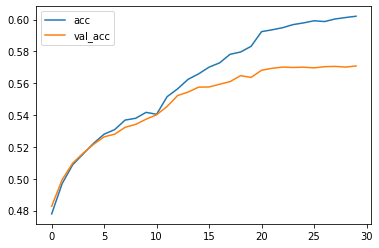

In [339]:
import matplotlib.pyplot as plt
loss = [v[0] for v in log]
acc = [v[1] for v in log]
val_loss = [v[2] for v in log]
val_acc = [v[3] for v in log]
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc', 'val_acc'])

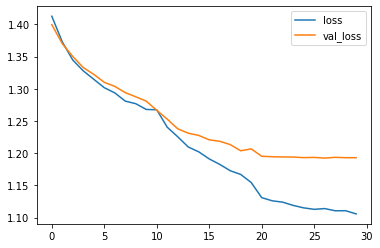

In [340]:
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])

This block is used to restore the latest checkpoint for futher training or evaluation.

In [ ]:
print(tf.train.latest_checkpoint(checkpoint_dir))
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Evaluation

In [332]:
@tf.function
def test_step(inp, enc_hidden):
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        predictions, attention_weights = decoder(enc_output)
    return predictions, attention_weights
def evaluate(test_data):
    enc_hidden = encoder.initialize_hidden_state()
    
    for batch, (inp, targ) in enumerate(test_data):
        if len(inp) != BATCH_SIZE:
            enc_hidden = tf.zeros((len(inp), units))
        # make prediction
        if batch == 0:
            predictions, attention_weights = test_step(inp, enc_hidden)
            predictions, attention_weights = predictions.numpy(), attention_weights.numpy()
        else:
            _predictions, _attention_weights = test_step(inp, enc_hidden)
            _predictions, _attention_weights = _predictions.numpy(), _attention_weights.numpy()
            print(_predictions)
            predictions = np.concatenate((predictions, _predictions))
            attention_weights = np.concatenate((attention_weights, _attention_weights))
    
    predictions = np.squeeze(predictions)
    attention_weights = np.squeeze(attention_weights)

    return predictions, attention_weights

def direct_evaluate(test_data, have_y=True):
    enc_hidden = encoder.initialize_hidden_state()

    for batch, data in enumerate(test_data):
        if have_y:
            (inp, targ) = data
        else:
            inp = data
        if len(inp) != BATCH_SIZE:
            enc_hidden = tf.zeros((len(inp), units))
        # make prediction
        if batch == 0:
            predictions, attention_weights = test_step(inp, enc_hidden)
            predictions, attention_weights = predictions.numpy(), attention_weights.numpy()
            classes_pred = np.argmax(predictions, axis=1)
            confs = np.max(tf.math.softmax(predictions), axis=1)
        else:
            predictions, attention_weights = test_step(inp, enc_hidden)
            predictions, attention_weights = predictions.numpy(), attention_weights.numpy()
            _classes_pred = np.argmax(predictions, axis=1)
            _confs = np.max(tf.math.softmax(predictions), axis=1)
            classes_pred = np.concatenate((classes_pred, _classes_pred))
            confs = np.concatenate((confs, _confs))
        print(f'evaluate {batch+1}/{len(test_data)}, {len(classes_pred)}', end='\r')
    return classes_pred, confs


In [341]:
y_pred, confs = direct_evaluate(test_dataset)
print('Accuracy: ', np.sum((y_pred == np.argmax(y_test[:len(y_pred)], axis=1))) / len(y_pred))

Accuracy: 138/1138, 291113 0.5703386657414818


The accuracy of this model in test dataset is about 0.57, but when I submit the whole prediction to kaggle, the accuracy dropped down by about 10 percent to 0.46. I might becouse the size of kaggle testing set is larger (411972 records) then my testing dataset(291113 records). But the accuracy dropped more then my expection, and this phenomenon happend in all my models' predictions, but I actually have no idea about this phenomenon.

In [310]:
predictions, weights = evaluate(test_dataset.take(2))

[[-1.9129748   1.5151832  -0.81625646 ... -0.2113112  -0.69584554
   0.99583757]
 [-2.3621933   0.7563931  -0.49146    ... -0.25605547 -1.0141022
   1.4187769 ]
 [-0.43325156  1.5299046  -2.0838528  ... -2.028525   -3.5406783
  -0.3163751 ]
 ...
 [-0.1897125  -0.508383    1.8668121  ...  1.5742817  -0.24298197
  -1.0779581 ]
 [-1.3331293  -0.27787232  3.6830027  ...  1.1604054   0.447672
   0.34599385]
 [ 0.01903293 -0.7510221   0.92993027 ...  1.2379054  -0.885535
  -0.2781862 ]]


In [110]:
weights.shape

(512, 8, 100)

In [342]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=np.argmax(y_test[:len(y_pred)], axis=1), y_pred=y_pred) 
print(cm)

[[ 1953   408  1501    98  1946  1827    32   181]
 [  126 29318  1506   477 13503  2752   156  2146]
 [  350  1134 12242   431  6037  6628   199   648]
 [   55  1017   818  5317  3790  1447    82   320]
 [  196  7376  2844   885 81563  4980   307  4792]
 [  325  1818  5649   634  9587 19540   265   927]
 [   53   610  1300   210  3457  1815  2084   287]
 [   64  4311  1291   350 18908  2118   106 14016]]


In [214]:
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

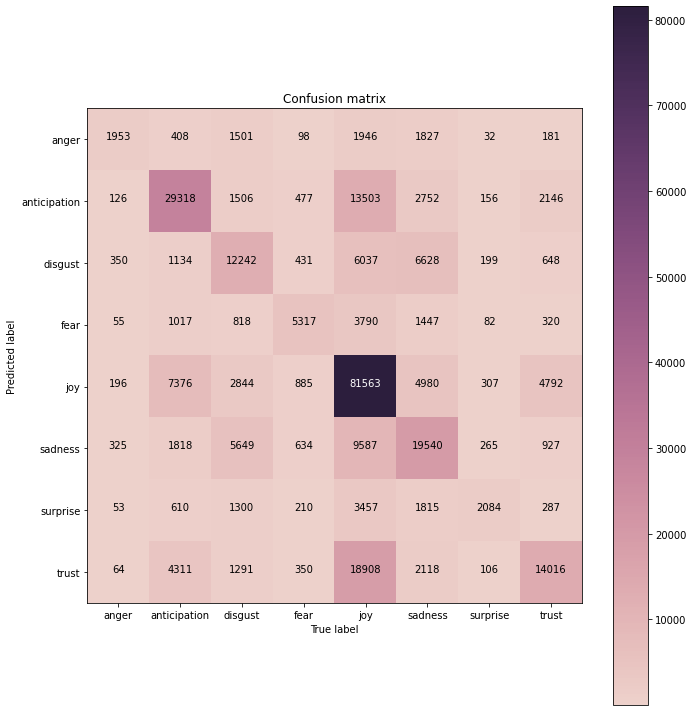

In [343]:
plot_confusion_matrix(cm, label.classes_, title='Confusion matrix')

Plotting the confusion matrix, I find that the `joy` class dominate the whole dataset, so the model tend to predict most of the record as joy emotion. Lots of records in classes like trust and anticipation predicted as joy, this may be the reason that the model has a poor performance. 

## Generate Output

In [ ]:
tweets_test['text_tokenized'] = tweets_test['text'].apply(lambda x: nltk.word_tokenize(preprocess_text(x)))
X_out = text_to_index(tweets_test['text_tokenized'])
X_out = tf.keras.preprocessing.sequence.pad_sequences(X_out, maxlen=max_length)

In [316]:
len(tweets_test)

411972

In [317]:
dataset_evaluate = tf.data.Dataset.from_tensor_slices(X_out)
dataset_evaluate = dataset_evaluate.batch(BATCH_SIZE, drop_remainder=False)

In [318]:
len(dataset_evaluate)

1610

In [344]:
y_pred, confs = direct_evaluate(dataset_evaluate, have_y=False)

In [345]:
df_ids = pd.DataFrame(tweets_test['tweet_id'])
df_ids = df_ids.rename(columns={'tweet_id': 'id'})
df_ids['emotion'] = label.classes_[y_pred]
df_ids['confidence'] = confs


In [346]:
df_ids['emotion'].value_counts()

joy             185966
sadness          77486
disgust          56389
anticipation     49017
trust            25918
fear              9763
anger             4430
surprise          3003
Name: emotion, dtype: int64

In [347]:
df_ids

,id,emotion,confidence
2,0x28b412,anticipation,0.598450
4,0x2de201,anticipation,0.730368
9,0x218443,joy,0.613454
30,0x2939d5,joy,0.629412
33,0x26289a,trust,0.871999
...,...,...,...
1867525,0x2913b4,anticipation,0.789367
1867529,0x2a980e,anticipation,0.633379
1867530,0x316b80,sadness,0.323782
1867531,0x29d0cb,joy,0.548834


In [348]:
df_ids.to_csv('./output.csv', index=False, columns=['id', 'emotion'])

In [99]:
X_test[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)